# Задача исследования отделений Почта Банка

Используемые библиотеки и версии:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

print('numpy version', np.__version__)
print('pandas version', pd.__version__)
print('matplotlib version', '3.0.2')
print('seaborn version', seaborn.__version__)

numpy version 1.19.5
pandas version 0.23.4
matplotlib version 3.0.2
seaborn version 0.9.0


## 1. Обработка данных

In [2]:
data = pd.read_csv('data.csv', ',')
data.head()

,id,post_id,open_date,street,address,place_type,shop_centre,dns,lat,lon,...,job_gov_count,metro_count,metro_min_distance,transport_count,transport_min_distance,working_days,work_hours,weekday_availability,office_hours,is_moscow
0,18017,NaN,2017.0,пл. Преображенская,"пл. Преображенская, дом 8",other,False,False,51.279520,37.502010,...,9,1,210.602515,19,90.504883,6.0,11.0,1.0,NaN,True
1,5546,NaN,2015.0,пл. Преображенская,"пл. Преображенская, д. 8",ТП,False,False,51.279520,37.502010,...,9,1,210.602515,19,90.504883,6.0,11.0,1.0,NaN,True
2,6211,NaN,2015.0,пл. Преображенская,"пл. Преображенская, д. 8 ТП №2",ТП,False,False,51.279520,37.502010,...,15,1,434.931238,23,25.471714,6.0,11.0,1.0,NaN,True
3,18067,NaN,2017.0,пл. Преображенская,"пл. Преображенская, дом 8",other,False,False,51.279520,37.502010,...,9,1,210.602515,19,90.504883,6.0,11.0,1.0,NaN,True
4,12748,141551.0,2017.0,рп Андреевка,"рп Андреевка, дом 3 Б",ОПС Б1,False,False,52.191502,30.293079,...,2,0,NaN,7,164.255410,6.0,11.0,1.0,NaN,False


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 33 columns):
id                        717 non-null int64
post_id                   545 non-null float64
open_date                 676 non-null float64
street                    717 non-null object
address                   717 non-null object
place_type                717 non-null object
shop_centre               717 non-null bool
dns                       717 non-null bool
lat                       717 non-null float64
lon                       717 non-null float64
response                  717 non-null object
district                  717 non-null object
post2                     717 non-null object
is_center                 717 non-null bool
price                     612 non-null float64
parking_count             717 non-null int64
parking_min_distance      704 non-null float64
finance_count             717 non-null int64
shop_count                717 non-null int64
distance_100             

По выводу видно, что есть данные о 717 отделениях. Больше половины численные (int64, float64), а так же есть бинарные (bool) и строковые (object). Так же в данных есть пропуски: 
 - post_id - почтовый индекс
 - open_date - дата открытия отделения
 - price - цена покупки жилья (квадратный метр)
 - parking_min_distance - минимальное расстояние до парковки
 - metro_min_distance - минимальное расстояние до станции метро
 - transport_min_distance - минимальное расстояние до ближайшей остановки
 - office_hours - "сырое" время работы отделения

Преобразуем некоторые категориальные признаки к численным.

### 1.3 Заполним пустые значения 

In [4]:
# post_id отображает лишь индекс отделения. Он нам не нужен для дальнейшего анализа
n_data = data.drop(["post_id"], axis=1)

# open_date, price - важные значения для анализа. Заменить на что-то мы не можем - просто удалим строки с пустыми значениями
n_data = n_data.dropna(subset=['open_date', 'price'])

# parking_min_distance, metro_min_distance, transport_min_distance - важные значения для анализа. Заменим пустое на очень большое значение.
maximum = [max(n_data['parking_min_distance']), max(n_data['metro_min_distance']), max(n_data['transport_min_distance'])]
n_data['parking_min_distance'] = n_data['parking_min_distance'].fillna(maximum[0] + 5000)
n_data['metro_min_distance'] = n_data['metro_min_distance'].fillna(maximum[1] + 5000)
n_data['transport_min_distance'] = n_data['transport_min_distance'].fillna(maximum[2] + 5000)

# office_hours важное значение. Пока заменим стандартным временем работы. Но лучше суммировать часы в будни и в выходные.
n_data['office_hours'] = n_data['office_hours'].fillna('пн.—пт.: 09:00—21:00 сб., вс.: 10:00—17:00')

Переведем office_hours в минуты. Если не можем, ставим среднее значение.

In [5]:
# переводим строку даты в количество дней
def date_to_count(dates):
    dates = dates.replace(':', '')
    if len(dates.split(',')) > 1:
        return 2
    elif len(dates.split('—')) > 1:
        dates = dates.replace('пн.', '1')
        dates = dates.replace('вт.', '2')
        dates = dates.replace('ср.', '3')
        dates = dates.replace('чт.', '4')
        dates = dates.replace('пт.', '5')
        dates = dates.replace('сб.', '6')
        dates = dates.replace('вс.', '7')
        days = dates.split('—')
        return int(days[1]) - int(days[0]) + 1
    else:
        return 1

# переводим строку часов работы в кол-во часов
def str_to_time(row):
    try:
        result = 0
        row = row.replace('., ', '.,').replace(', ', ' ').replace("['", '').replace("']", '')
        row = row.replace('—:', '—')
        arr = row.split(' ')
        for i in range(0, len(arr) - 1, 2):
            dates = arr[i]
            arr[i + 1] = arr[i + 1].replace('–', '—')
            hours = [arr[i + 1].split('—')[0], arr[i + 1].split('—')[1]]
            time = int(hours[1].split(':')[0]) * 60 + int(hours[1].split(':')[1]) - (int(hours[0].split(':')[0]) * 60 + int(hours[0].split(':')[1]))
            result += time * date_to_count(dates)
        return result
    except Exception:
        return 4440

n_data.office_hours = n_data.office_hours.apply(str_to_time)
n_data.office_hours[4:8]

7     4440
8     6420
9     4440
10    2640
Name: office_hours, dtype: int64

In [6]:
print(data.place_type.unique())
n_data["place_type"].replace(
    {"other": "0", "ТП": "1", "ОПС Б1": "2", "ОПС Б1_2": "3", "КЦ": "4"},
    inplace=True
)
n_data["place_type"] = n_data["place_type"].astype(int)

['other' 'ТП' 'ОПС Б1' 'ОПС Б1_2' 'КЦ']


Для начала разделим признаки на целочисленные (сюда и бинарные), вещественные и категориальные:

In [7]:
bool_vals = ["shop_centre", "dns", "is_center", "is_moscow"]
n_data[bool_vals] = data[bool_vals].astype(int)
# post_id don't need
real_features = ["open_date", "place_type", "lat", "lon", "price", "parking_min_distance", "distance_100", "distance_500",
                 "metro_min_distance", "transport_min_distance", "working_days", "work_hours", "weekday_availability"]
# id don't need
discrete_features = ["parking_count", "finance_count", "shop_count", "cafe_count", "culture_count", "job_gov_count",
                     "metro_count", "transport_count", "office_hours"]
discrete_features.extend(bool_vals)
cat_features = ["street", "adress", "response", "district", "post2"]

### 1.1 Гистограммы

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002C7B1908>,
      dtype=object)

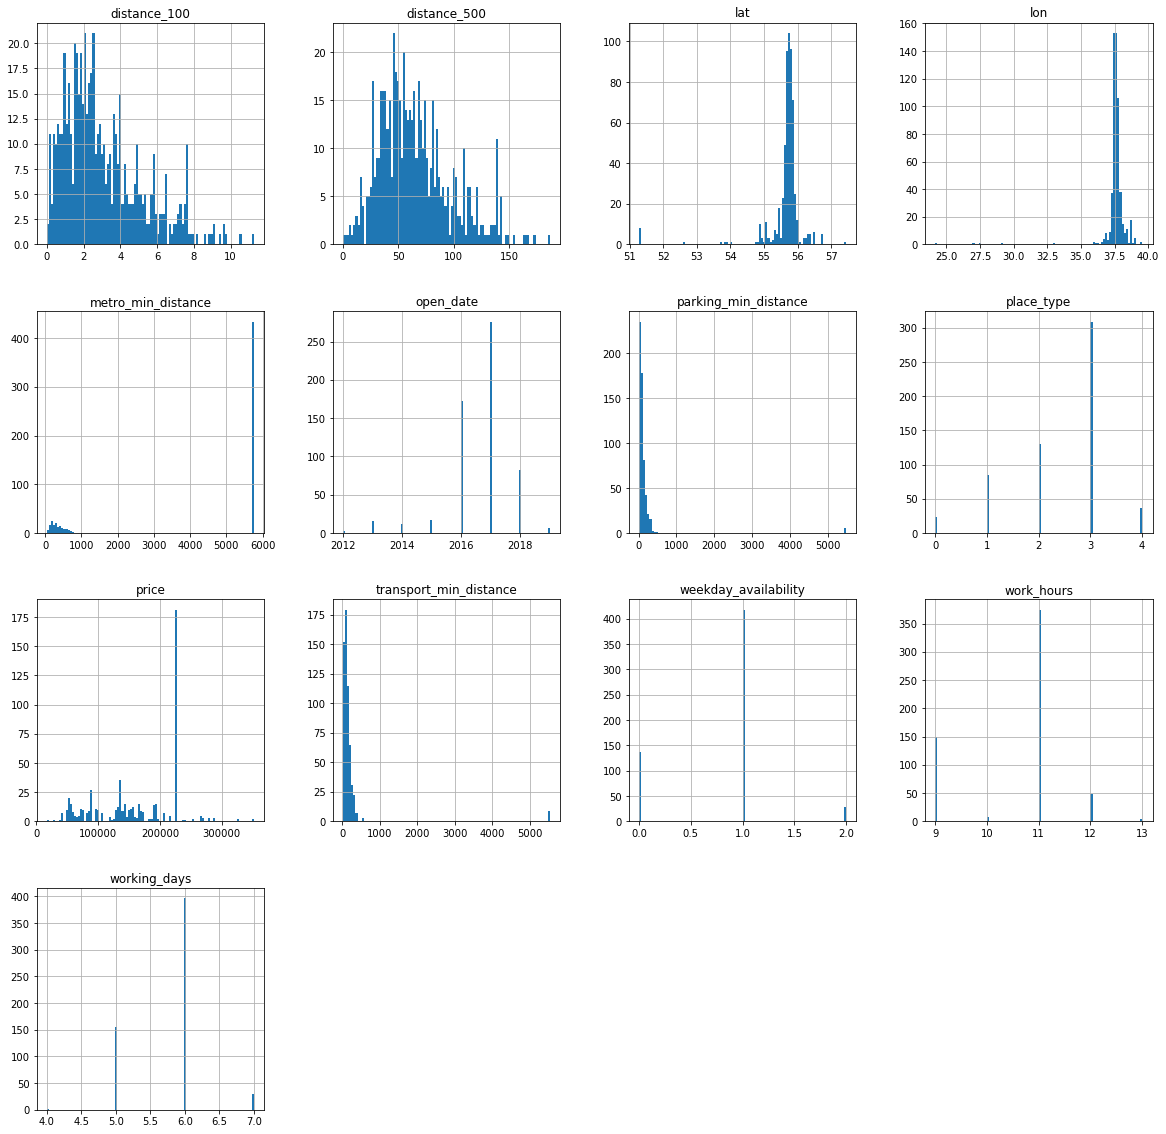

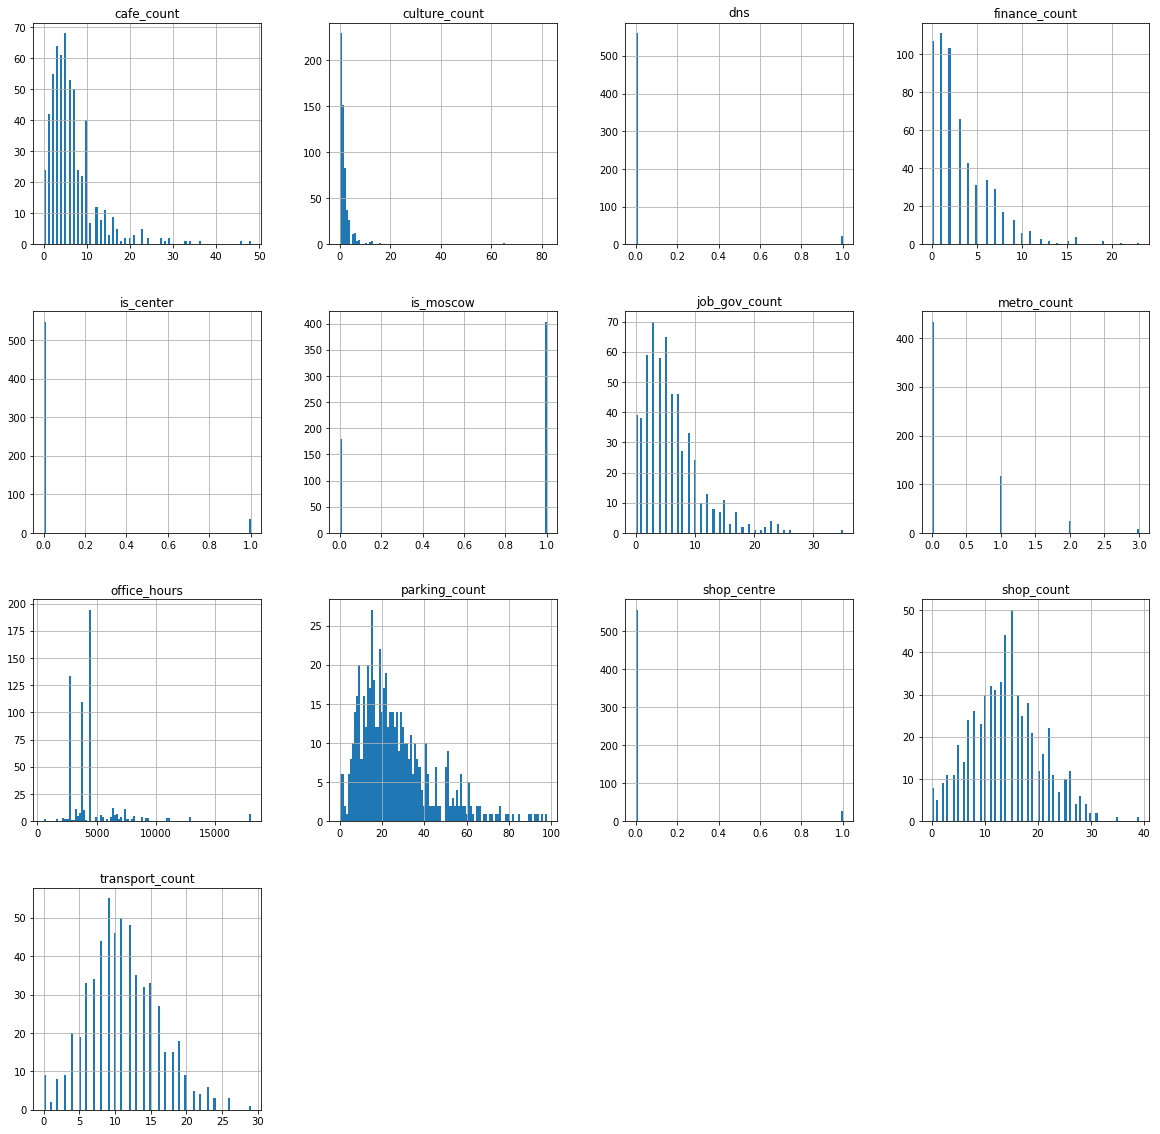

In [8]:
n_bins = 100
n_data[real_features].hist(bins=n_bins, figsize=(20, 20))
n_data[discrete_features].hist(bins=n_bins, figsize=(20, 20))

По построенным гистограммам целочисленных и вещественных признаков можно сделать вывод:
 1. Нет константных значений
 2. Общую выборку нельзя описать нормальным распределением
 3. Иногда попадаются далеко отстоящие от общего распределения значения, которые могут помешать работе алгоритма

### 1.2 Корреляции 

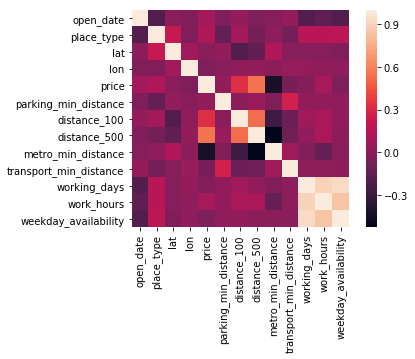

In [9]:
seaborn.heatmap(n_data[real_features].corr(), square=True)

Видно, что признаки "количество рабочих дней в неделе", "максимальная продолжительность рабочего дня", "количество нерабочих дней на неделе" коррелируют друг с другом

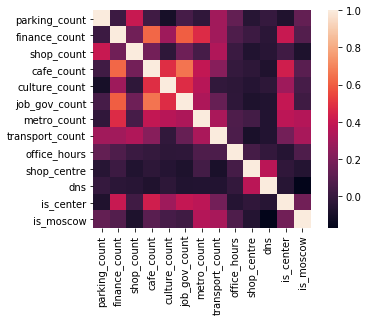

In [10]:
seaborn.heatmap(n_data[discrete_features].corr(), square=True)

In [11]:
n_data.shape

(583, 32)

## 2. Кластеризация отделений

### 2.1. Понижение размерности TSNE
Сначала воспользуемся методом TSNE:

In [12]:
from sklearn.preprocessing import scale

selected_features = real_features + discrete_features
# objects_with_nan = n_data.index[np.any(np.isnan(n_data[selected_features].values), axis=1)]   
data_subset = scale(n_data[selected_features]) # поинжение размерности плохо работает с разномасштабными данными
# .drop(objects_with_nan, axis=0)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by the scale function.
  """


In [13]:
data_subset.shape

(583, 26)

In [14]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

In [15]:
model = TSNE(random_state=321)
# model.fit(data_subset, response_subset)
tsne_representation = model.fit_transform(data_subset)

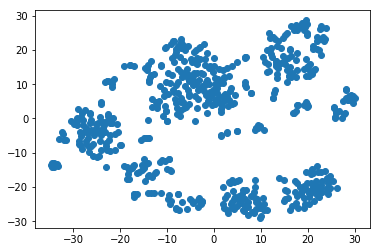

In [16]:
X = [coord[0] for coord in tsne_representation]
Y = [coord[1] for coord in tsne_representation]
plt.scatter(X, Y)

### 2.2 понижение размерности. MDS

In [17]:
from sklearn.manifold import MDS

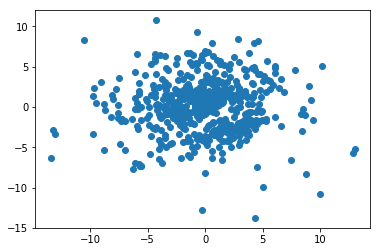

In [18]:
model2 = MDS(random_state=321)
# model2.fit(data_subset, response_subset)
MDS_transformed = model2.fit_transform(data_subset)
X = [coord[0] for coord in MDS_transformed]
Y = [coord[1] for coord in MDS_transformed]
plt.scatter(X, Y)

### 2.3 Кластеризация K_Means

K_Means

In [19]:
from sklearn.cluster import KMeans

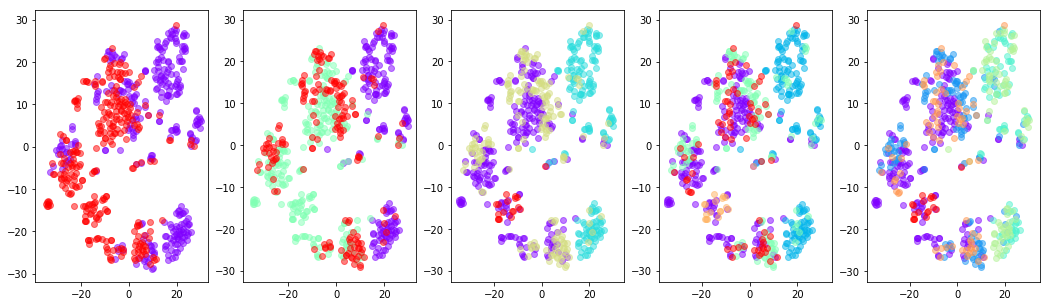

In [20]:
figure, axes = plt.subplots(1, 5, figsize=(18, 5))

for i in range(5):
    cluster_count = i + 2
    model = KMeans(n_clusters=cluster_count, random_state=1)
    preds = model.fit_predict(n_data[selected_features])
    colors = cm.rainbow(np.linspace(0, 1, cluster_count))
    
    for y, c in zip(set(preds), colors):
        axes[i].scatter(tsne_representation[preds==y, 0], 
                tsne_representation[preds==y, 1], c=[c], alpha=0.5, label=str(y))

Видим что метод к-средних не очень согласуется с понижением размерности TSNE

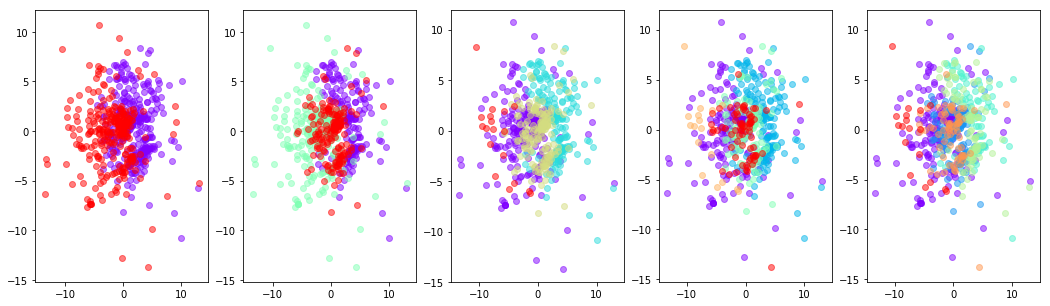

In [21]:
figure, axes = plt.subplots(1, 5, figsize=(18, 5))

for i in range(5):
    cluster_count = i + 2
    model = KMeans(n_clusters=cluster_count, random_state=1)
    preds = model.fit_predict(n_data[selected_features])
    colors = cm.rainbow(np.linspace(0, 1, cluster_count))
    
    for y, c in zip(set(preds), colors):
        axes[i].scatter(MDS_transformed[preds==y, 0], 
                MDS_transformed[preds==y, 1], c=[c], alpha=0.5, label=str(y))

### 2.4 Кластеризация DBSCAN
Так как данных относительно много, а кластеров необходимо получить немного, решено было попробовать данный метод

In [22]:
from sklearn.cluster import DBSCAN

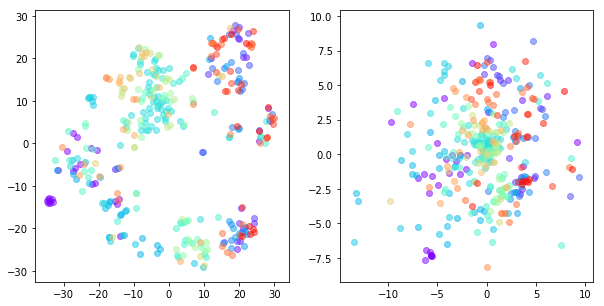

In [23]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))

model = DBSCAN(eps=180, min_samples=2)
preds = model.fit_predict(n_data[selected_features])
cluster_count = max(preds)
colors = cm.rainbow(np.linspace(0, 1, cluster_count))

for y, c in zip(set(preds), colors):
    axes[0].scatter(tsne_representation[preds==y, 0], 
            tsne_representation[preds==y, 1], c=[c], alpha=0.5, label=str(y))

for y, c in zip(set(preds), colors):
    axes[1].scatter(MDS_transformed[preds==y, 0], 
            MDS_transformed[preds==y, 1], c=[c], alpha=0.5, label=str(y))

DBSCAN не позволяет получить хороших результатов

## 3. Интерпретация однородных групп отделений

### 3.1 TSNE интерпретация
Возьмём по 10 элементов из полученных на прошлом этапе 3 ярко выраженных кластеров:

In [24]:
def in_first(coord):
    if coord[0] < -20:
        return True
    return False

def in_second(coord):
    if coord[0] > -20 and coord[0] < 20 and coord[1] > 0:
        return True
    return False

def in_third(coord):
    if coord[0] > 0 and coord[1] < 0:
        return True
    return False

In [25]:
cluster_1 = []
cluster_2 = []
cluster_3 = []
for i in range(len(tsne_representation)):
    coord = tsne_representation[i]
    if in_first(coord):
        cluster_1.append(i)
    if in_second(coord):
        cluster_2.append(i)
    if in_third(coord):
        cluster_3.append(i)
print(cluster_1)

[0, 1, 2, 3, 101, 112, 114, 115, 116, 117, 118, 119, 120, 121, 124, 127, 128, 129, 142, 146, 159, 162, 175, 176, 180, 181, 182, 186, 187, 188, 189, 191, 194, 195, 196, 205, 206, 207, 233, 242, 249, 256, 257, 261, 291, 301, 303, 304, 316, 330, 332, 337, 338, 343, 346, 350, 355, 356, 365, 372, 373, 379, 380, 385, 390, 392, 413, 415, 423, 428, 429, 430, 431, 432, 434, 436, 437, 439, 442, 443, 450, 459, 460, 461, 462, 464, 471, 476, 487, 492]


In [26]:
print('elements in first cluster')
n_data[selected_features[1:21]].iloc[cluster_1][0:10]

elements in first cluster


,place_type,lat,lon,price,parking_min_distance,distance_100,distance_500,metro_min_distance,transport_min_distance,working_days,work_hours,weekday_availability,parking_count,finance_count,shop_count,cafe_count,culture_count,job_gov_count,metro_count,transport_count
0,0,51.279520,37.502010,227892.0,22.437756,7.648714,139.203857,210.602515,90.504883,6.0,11.0,1.0,51,7,16,10,2,9,1,19
1,1,51.279520,37.502010,227892.0,22.437756,7.648714,139.203857,210.602515,90.504883,6.0,11.0,1.0,51,7,16,10,2,9,1,19
2,1,51.279520,37.502010,227892.0,39.888740,11.275286,111.105429,434.931238,25.471714,6.0,11.0,1.0,39,8,15,12,2,15,1,23
3,0,51.279520,37.502010,227892.0,22.437756,7.648714,139.203857,210.602515,90.504883,6.0,11.0,1.0,51,7,16,10,2,9,1,19
149,4,55.795657,37.713828,188169.0,22.437756,7.648714,139.203857,210.602515,90.504883,6.0,11.0,1.0,51,7,15,10,2,9,1,19
160,0,55.822354,37.969922,227892.0,44.776119,2.926286,80.474857,385.008817,130.308851,6.0,12.0,1.0,13,7,3,0,1,7,1,8
162,4,55.686165,37.554914,217230.0,86.647544,2.585143,166.677714,188.923920,77.504231,6.0,11.0,1.0,21,11,19,12,0,4,2,13
163,4,55.822354,37.969922,227892.0,118.242966,6.531571,109.307000,103.674955,74.615671,6.0,11.0,1.0,23,5,16,2,1,13,1,16
164,4,55.846282,37.361640,141923.0,42.960710,3.274143,92.802000,304.881573,90.171985,6.0,11.0,1.0,29,5,22,4,1,6,1,11
165,4,55.613395,37.694556,227892.0,55.092623,5.770857,140.409143,123.443754,36.414546,6.0,11.0,1.0,27,6,16,4,1,8,1,22


In [27]:
print('elements in second cluster')
# for i in range(5):
#     print(cluster_2[i])
n_data[selected_features[1:21]].iloc[cluster_2][0:10]

elements in second cluster


,place_type,lat,lon,price,parking_min_distance,distance_100,distance_500,metro_min_distance,transport_min_distance,working_days,work_hours,weekday_availability,parking_count,finance_count,shop_count,cafe_count,culture_count,job_gov_count,metro_count,transport_count
7,4,55.797190,37.947279,82897.0,77.212664,3.715286,70.913286,5763.66332,82.434823,7.0,12.0,2.0,41,5,24,17,4,16,0,6
9,3,55.745591,37.983116,82897.0,96.138405,4.043286,74.704000,5763.66332,201.543664,6.0,11.0,1.0,26,3,24,11,4,11,0,14
11,2,55.750349,37.993350,82897.0,62.441775,4.640286,40.884714,5763.66332,35.272544,6.0,9.0,1.0,38,1,26,6,1,7,0,9
24,3,55.557042,37.709940,94885.0,24.717157,3.545429,46.315857,5763.66332,30.460196,6.0,11.0,1.0,37,2,13,3,4,18,0,8
25,0,56.031936,35.958705,47674.0,49.619851,0.555429,16.255857,5763.66332,101.058113,6.0,11.0,1.0,25,1,11,10,1,7,0,2
26,4,55.322185,38.666448,48626.0,201.725957,2.997000,26.514714,5763.66332,71.474463,7.0,12.0,2.0,6,2,12,5,1,9,0,4
27,3,55.314275,38.656188,48626.0,111.036150,1.859714,16.543143,5763.66332,72.537928,6.0,11.0,1.0,6,2,4,4,0,0,0,7
39,3,53.848680,27.065497,98715.0,257.565413,0.389857,22.124714,5763.66332,75.553943,5.0,9.0,1.0,14,0,7,5,3,8,0,6
40,4,56.342151,37.521065,69178.0,66.317214,1.548143,29.766143,5763.66332,174.776693,7.0,12.0,2.0,11,2,8,9,13,10,0,4
43,2,56.364551,37.530475,69178.0,29.597809,0.580143,11.079429,5763.66332,95.481568,6.0,11.0,1.0,9,1,5,2,2,1,0,8


In [28]:
print('elements in third cluster')
n_data[selected_features[1:21]].iloc[cluster_3][0:10]

elements in third cluster


,place_type,lat,lon,price,parking_min_distance,distance_100,distance_500,metro_min_distance,transport_min_distance,working_days,work_hours,weekday_availability,parking_count,finance_count,shop_count,cafe_count,culture_count,job_gov_count,metro_count,transport_count
10,2,55.753320,37.958535,82897.0,151.494375,0.724286,54.174429,5763.66332,172.381598,5.0,9.0,1.0,12,1,17,5,3,5,0,3
13,2,55.745605,37.912746,82897.0,24.672053,1.177857,26.887857,5763.66332,250.650746,5.0,9.0,0.0,22,1,12,1,4,0,0,9
14,3,55.794960,37.976655,82897.0,181.997775,0.975286,36.933000,5763.66332,276.273656,5.0,9.0,0.0,27,4,28,9,1,2,0,9
23,2,55.549423,37.716576,94885.0,30.036734,5.101714,70.916286,5763.66332,37.178862,5.0,9.0,0.0,69,5,39,4,1,21,0,10
28,2,55.244907,38.766981,48626.0,63.883387,0.207429,12.725571,5763.66332,131.243602,5.0,9.0,0.0,9,2,12,0,2,2,0,4
29,2,55.322749,38.679739,48626.0,118.111014,1.538571,45.890286,5763.66332,65.032507,5.0,9.0,0.0,15,5,19,4,2,9,0,9
30,2,55.285921,38.741672,48626.0,94.881831,0.700571,4.265714,5763.66332,545.481041,5.0,9.0,0.0,5,1,8,1,0,2,0,1
31,1,55.906368,36.859286,48626.0,5480.630619,0.899429,65.963000,5763.66332,304.150029,6.0,11.0,1.0,0,0,0,0,0,0,0,8
41,3,56.353501,37.522876,69178.0,37.320895,1.626000,51.053143,5763.66332,167.545208,5.0,9.0,0.0,25,0,12,6,2,3,0,4
47,2,55.973470,37.504421,119387.0,91.794078,2.385571,44.173286,5763.66332,194.100159,5.0,9.0,0.0,12,4,18,5,1,5,0,4


Вывод по методу TSNE:

1 группа отделений находится у метро, у второй группы больше в среднем рабочих часов (work_hours), чем у третьей.

### 3.2 K_Means интерпретация
Рассмотрим данные для 3х кластеров (для 4х кол-во элементов в кластере становится неравномерным)

In [29]:
model = KMeans(n_clusters=3, random_state=1)
preds = model.fit_predict(n_data[selected_features])
km_1 = n_data[preds==0]
print(km_1.shape)
km_2 = n_data[preds==1]
print(km_2.shape)
km_3 = n_data[preds==2]
print(km_3.shape)

(169, 32)
(246, 32)
(168, 32)


In [32]:
print('elements in first cluster')
km_1[selected_features[1:21]][0:10]

elements in first cluster


,place_type,lat,lon,price,parking_min_distance,distance_100,distance_500,metro_min_distance,transport_min_distance,working_days,work_hours,weekday_availability,parking_count,finance_count,shop_count,cafe_count,culture_count,job_gov_count,metro_count,transport_count
7,4,55.797190,37.947279,82897.0,77.212664,3.715286,70.913286,5763.66332,82.434823,7.0,12.0,2.0,41,5,24,17,4,16,0,6
8,3,55.778471,37.895601,82897.0,72.852029,1.558143,32.025000,5763.66332,97.014925,7.0,11.0,2.0,15,0,17,5,1,2,0,8
9,3,55.745591,37.983116,82897.0,96.138405,4.043286,74.704000,5763.66332,201.543664,6.0,11.0,1.0,26,3,24,11,4,11,0,14
10,2,55.753320,37.958535,82897.0,151.494375,0.724286,54.174429,5763.66332,172.381598,5.0,9.0,1.0,12,1,17,5,3,5,0,3
11,2,55.750349,37.993350,82897.0,62.441775,4.640286,40.884714,5763.66332,35.272544,6.0,9.0,1.0,38,1,26,6,1,7,0,9
13,2,55.745605,37.912746,82897.0,24.672053,1.177857,26.887857,5763.66332,250.650746,5.0,9.0,0.0,22,1,12,1,4,0,0,9
14,3,55.794960,37.976655,82897.0,181.997775,0.975286,36.933000,5763.66332,276.273656,5.0,9.0,0.0,27,4,28,9,1,2,0,9
23,2,55.549423,37.716576,94885.0,30.036734,5.101714,70.916286,5763.66332,37.178862,5.0,9.0,0.0,69,5,39,4,1,21,0,10
24,3,55.557042,37.709940,94885.0,24.717157,3.545429,46.315857,5763.66332,30.460196,6.0,11.0,1.0,37,2,13,3,4,18,0,8
25,0,56.031936,35.958705,47674.0,49.619851,0.555429,16.255857,5763.66332,101.058113,6.0,11.0,1.0,25,1,11,10,1,7,0,2


In [33]:
print('elements in second cluster')
km_2[selected_features[1:21]][0:10]

elements in second cluster


,place_type,lat,lon,price,parking_min_distance,distance_100,distance_500,metro_min_distance,transport_min_distance,working_days,work_hours,weekday_availability,parking_count,finance_count,shop_count,cafe_count,culture_count,job_gov_count,metro_count,transport_count
0,0,51.279520,37.502010,227892.0,22.437756,7.648714,139.203857,210.602515,90.504883,6.0,11.0,1.0,51,7,16,10,2,9,1,19
1,1,51.279520,37.502010,227892.0,22.437756,7.648714,139.203857,210.602515,90.504883,6.0,11.0,1.0,51,7,16,10,2,9,1,19
2,1,51.279520,37.502010,227892.0,39.888740,11.275286,111.105429,434.931238,25.471714,6.0,11.0,1.0,39,8,15,12,2,15,1,23
3,0,51.279520,37.502010,227892.0,22.437756,7.648714,139.203857,210.602515,90.504883,6.0,11.0,1.0,51,7,16,10,2,9,1,19
149,4,55.795657,37.713828,188169.0,22.437756,7.648714,139.203857,210.602515,90.504883,6.0,11.0,1.0,51,7,15,10,2,9,1,19
150,0,55.776852,37.661268,227892.0,233.678632,0.386286,49.442000,594.870215,243.500956,6.0,11.0,1.0,20,10,20,19,4,14,2,13
151,0,55.676826,37.500209,227892.0,152.189413,0.876857,84.930143,357.075321,190.545640,5.0,9.0,0.0,18,5,14,2,0,7,1,14
154,0,55.722678,37.636136,227892.0,37.669939,1.976429,103.635000,93.044470,94.867156,5.0,9.0,0.0,34,16,15,23,4,23,2,17
155,2,55.730568,37.641927,227892.0,53.881424,6.346857,90.806571,320.926760,18.034397,6.0,12.0,1.0,30,13,9,17,3,16,2,19
156,0,55.730568,37.641927,227892.0,69.447105,3.980571,90.142143,447.707708,94.717340,6.0,12.0,1.0,22,14,9,11,4,12,2,20


In [34]:
print('elements in third cluster')
km_3[selected_features[1:21]][0:10]

elements in third cluster


,place_type,lat,lon,price,parking_min_distance,distance_100,distance_500,metro_min_distance,transport_min_distance,working_days,work_hours,weekday_availability,parking_count,finance_count,shop_count,cafe_count,culture_count,job_gov_count,metro_count,transport_count
46,3,55.938437,37.507047,119387.0,68.644548,0.969286,43.581143,5763.663320,103.311725,6.0,9.0,1.0,26,2,18,8,1,7,0,16
47,2,55.973470,37.504421,119387.0,91.794078,2.385571,44.173286,5763.663320,194.100159,5.0,9.0,0.0,12,4,18,5,1,5,0,4
48,2,55.941193,37.491603,119387.0,41.537075,1.892143,30.666429,5763.663320,104.077057,5.0,9.0,0.0,20,3,20,6,1,5,0,12
49,2,55.925226,37.526654,119387.0,202.354431,1.172143,22.138429,5763.663320,273.118016,5.0,9.0,0.0,13,1,15,6,0,2,0,9
152,0,55.898435,37.534201,134823.0,227.234823,0.113714,18.796429,5763.663320,542.394097,6.0,11.0,1.0,7,0,3,1,0,7,0,2
153,0,55.839365,37.652069,181534.0,41.751047,1.283429,22.164286,5763.663320,136.216007,6.0,11.0,1.0,4,1,3,0,0,7,0,6
158,0,55.744891,37.798978,137743.0,88.053377,1.132714,57.973000,5763.663320,137.437079,5.0,9.0,0.0,57,0,12,5,1,2,0,15
164,4,55.846282,37.361640,141923.0,42.960710,3.274143,92.802000,304.881573,90.171985,6.0,11.0,1.0,29,5,22,4,1,6,1,11
168,4,55.746224,37.781968,142918.0,87.986942,5.849286,68.859857,209.409155,35.082565,6.0,11.0,1.0,85,7,15,5,2,4,1,15
174,4,55.850473,37.643794,166074.0,31.057690,3.745429,61.447143,5763.663320,94.984493,7.0,12.0,2.0,43,0,6,1,0,0,0,12


в метод к-средних можно увидеть разницу кластеров по цене. В первом кластере цена маленькая, нет метро. Второй кластер отделений похож на бизнес-центры, где большой поток людей, большая цена аренды и много финансовых и культурных заведений. Третий кластер является средним между первыми двумя.

## 4. Выделение типичных и аномальных точек

In [35]:
from sklearn import svm

In [36]:
interesting_features = ["lat", "lon", "price", "parking_min_distance",
                 "metro_min_distance", "transport_min_distance", "working_days"]
features_svm = discrete_features + real_features
# features_svm = real_features

In [37]:
svm_ = svm.OneClassSVM(kernel='rbf', gamma=100, nu=0.0008) # gamma=10, nu=0.01 scale) 
print(svm_.fit(n_data[features_svm]))
labels = svm_.predict(n_data[features_svm])
print('mean = ', (labels==1).mean())

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=100, kernel='rbf',
      max_iter=-1, nu=0.0008, random_state=None, shrinking=True, tol=0.001,
      verbose=False)
mean =  0.8816466552315609


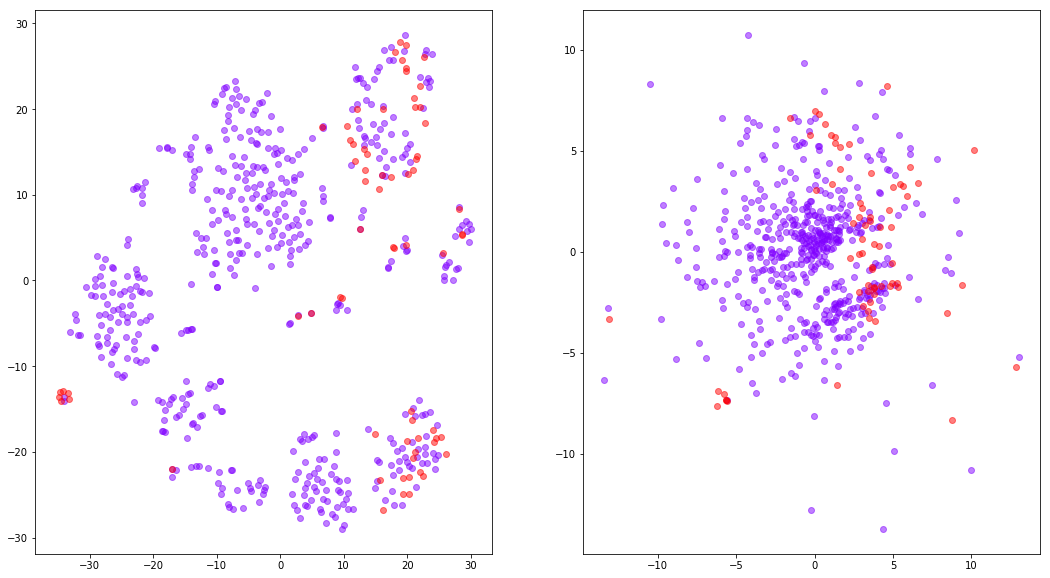

In [38]:
figure, axes = plt.subplots(1, 2, figsize=(18, 10))

cluster_count = 2
colors = cm.rainbow(np.linspace(0, 1, cluster_count))

for y, c in zip(set(labels), colors):
    axes[0].scatter(tsne_representation[labels==y, 0], 
            tsne_representation[labels==y, 1], c=[c], alpha=0.5, label=str(y))

for y, c in zip(set(labels), colors):
    axes[1].scatter(MDS_transformed[labels==y, 0], 
            MDS_transformed[labels==y, 1], c=[c], alpha=0.5, label=str(y))

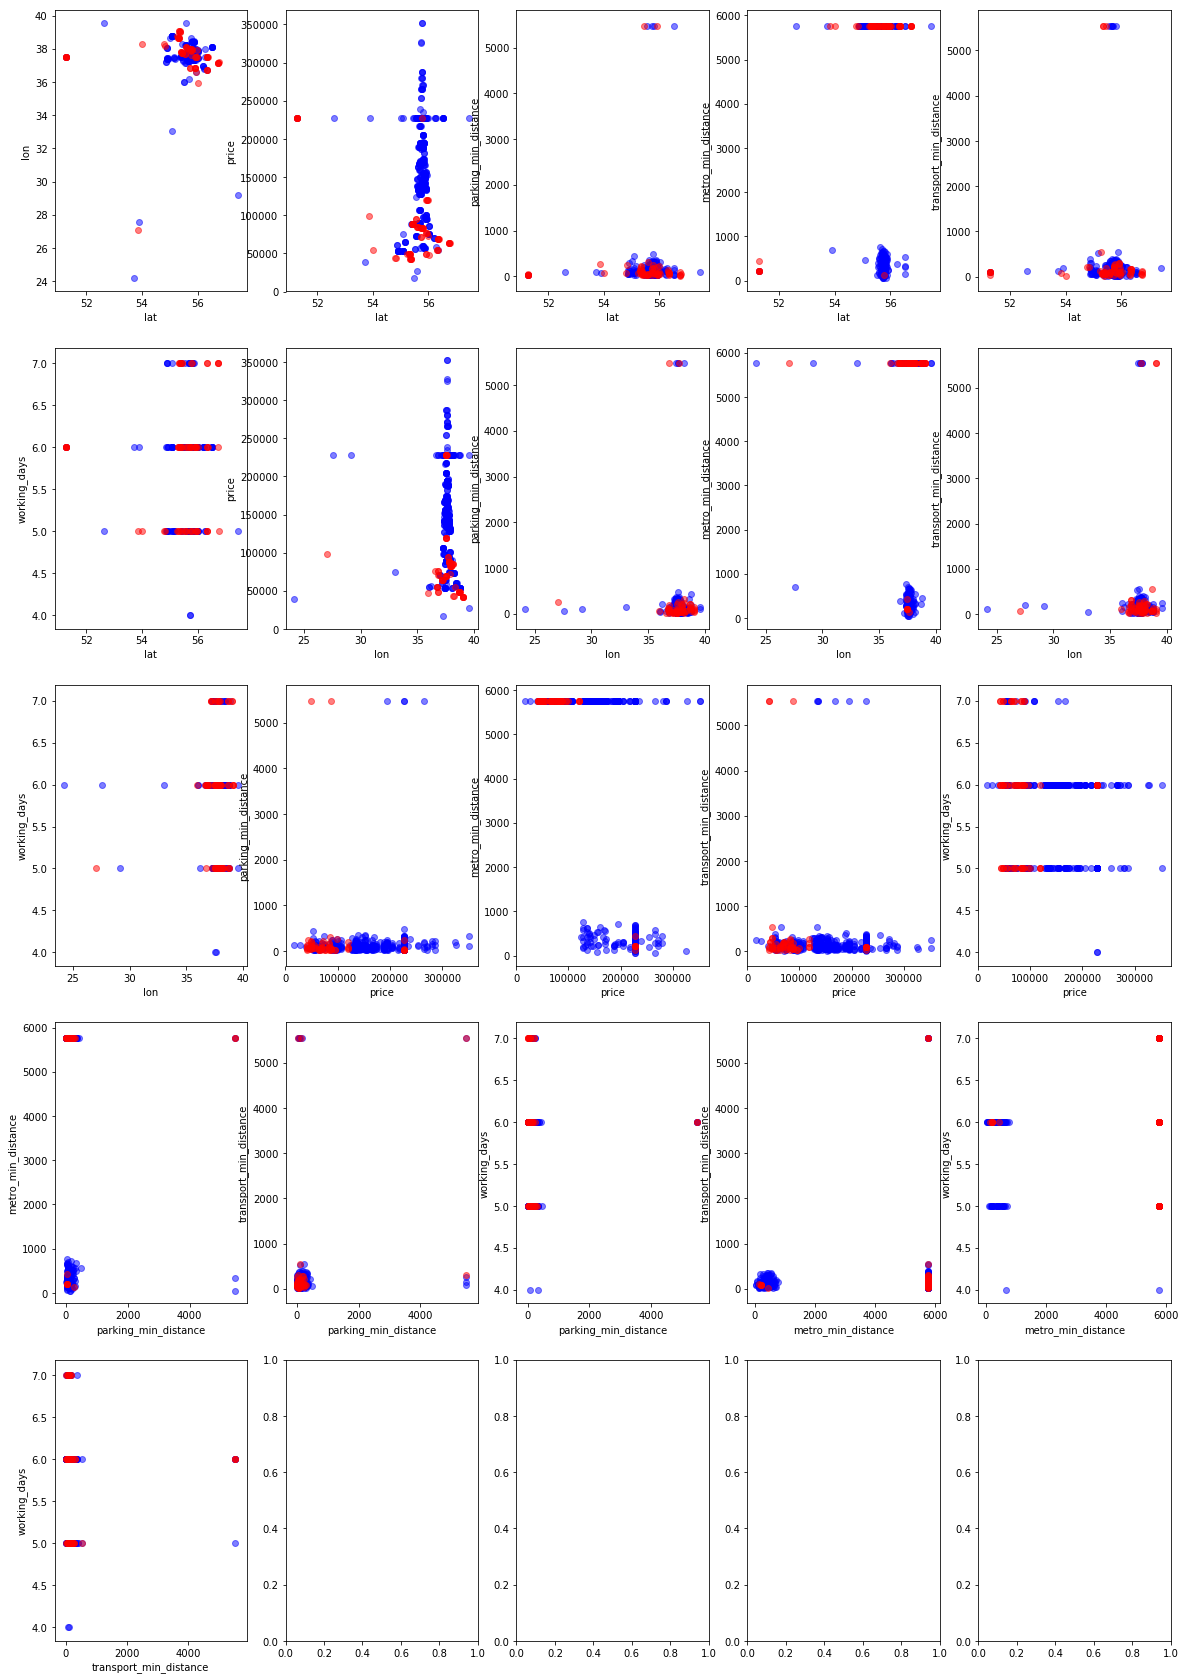

In [39]:
colors = ['red', 'blue']
bound = 5
figure, axes = plt.subplots(bound, bound, figsize=(20, 30))
count = 0
for i in range(len(interesting_features) - 1):
    for j in range(i + 1, len(interesting_features)):
        arr = [interesting_features[i], interesting_features[j]]
        axes[count // bound, count % bound].scatter(n_data[arr].values[labels==1, 0], 
                n_data[arr].values[labels==1, 1], c=colors[1], alpha=0.5)
        axes[count // bound, count % bound].scatter(n_data[arr].values[labels==-1, 0], 
                n_data[arr].values[labels==-1, 1], c=colors[0], alpha=0.5)
        axes[count // bound, count % bound].set_xlabel(interesting_features[i])
        axes[count // bound, count % bound].set_ylabel(interesting_features[j])
        count+=1

### Вывод: 
по графику аномалий цен покупки жилья от широт и долгот мы можем наблюдать точки, где цены в Москве ниже чем обычно. Также важно оценивать такие цены при отсутствии транспорта или метро. На графике аномалий также видно, что алгоритм считает странным близкое положение транспорта и большое количество рабочих дней в отсутствие метро

## Формулировка рекомендаций

Основная польза данного программного решения - своевременный поиск аномалий в работе отделений. Это позволит в реальном времени определять:
 - где людей стало меньше, а цена аренды жилья не изменилась
 - где, наоборот, появилось метро и увеличилась плотность населения
 - отделения, где среднее рабочее время сильно упало/ возросло
 - и т. д.

Разбиение на кластеры позволяет определять для каждой выборки отделений свои правила работы. Ориентируясь на полученные данные можно, например, составлять более эффективную рекламу для клиентов.

В данных нет однозначной оценки качества отделения (прибыли). Желательно добавить её среднее ежегодное значение для более качественного оценивания. Тогда можно было определять, относится ли новое место для открытия к максимально прибыльному кластеру или нет.

Можно также попробовать выставить оценку по требуемым гиперпараметрам (весам признаков, которые укажет руководство). Например, result = w1 * parking_count + w2 * distance_100 - w3 * price - w4 * metro_min_distance и т. д.

In [40]:
weights = [
    1, # вес для parking_count
    5, # вес для finance_count
    0, # вес для shop_count
    2, # вес для distance_100
    5, # вес для culture_count
    5, # вес для job_gov_count
    10, # вес для metro_count
    0, # вес для transport_count
    -0.002, # вес для price
    0, # вес для transport_min_distance
    -0.005, # вес для metro_min_distance
    0, # вес для parking_min_distance
]
main_features = ['parking_count', 'finance_count', 'shop_count', 'distance_100', 'culture_count', 'job_gov_count', 'metro_count',
                 'transport_count', 'price', 'transport_min_distance', 'metro_min_distance', 'parking_min_distance']

In [41]:
# def scalar_dot(a, b)

n_data['score'] = np.dot(n_data[main_features], weights)

In [42]:
n_data.score.describe()

count    583.000000
mean    -247.981653
std      131.155343
min     -608.776602
25%     -353.856473
50%     -257.884602
75%     -145.673602
max      121.275447
Name: score, dtype: float64

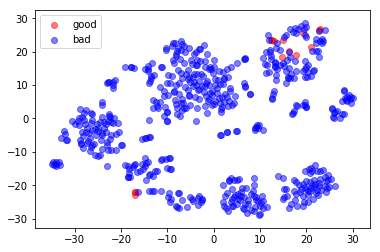

In [43]:
plt.scatter(tsne_representation[(n_data.score > 0), 0], tsne_representation[(n_data.score > 0), 1], c=["red"], alpha=0.5, label='good')
plt.scatter(tsne_representation[(n_data.score < 0), 0], tsne_representation[(n_data.score < 0), 1], c=["blue"], alpha=0.5, label='bad')
plt.legend()

Так мы можем определять, в каком направлении кластеров стоит развиваться. Так же можно искать самые "плохие" отделения:

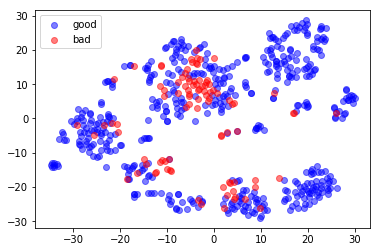

In [44]:
plt.scatter(tsne_representation[(n_data.score > -400), 0], tsne_representation[(n_data.score > -400), 1], c=["blue"], alpha=0.5, label='good')
plt.scatter(tsne_representation[(n_data.score < -400), 0], tsne_representation[(n_data.score < -400), 1], c=["red"], alpha=0.5, label='bad')
plt.legend()